Import modules into memory.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt


from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

# You may load additional libraries
from sklearn.svm import SVC,LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# The below suppresses all warnings in the notebook
# Only leave this uncommented for display purposes
import warnings
warnings.filterwarnings("ignore")

Load images into memory corresponding to people who have at least 50 pictures of them in the database.<br>
This correspond to the 12 people listed below.

In [2]:
faces = fetch_lfw_people(min_faces_per_person=50)

X = faces.data
y = faces.target

print("\nLabel of the 12 Classes:\n", faces.target_names)
print("\nData Matrix Dimension: ", X.shape)
# Below corresponds to the total number of pixels in the flattened images
print("\nLength of the Class Label Array:", y.shape)


Label of the 12 Classes:
 ['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Jacques Chirac' 'Jean Chretien'
 'John Ashcroft' 'Junichiro Koizumi' 'Serena Williams' 'Tony Blair']

Data Matrix Dimension:  (1560, 2914)

Length of the Class Label Array: (1560,)


Below we look at what 15 of the images look like.

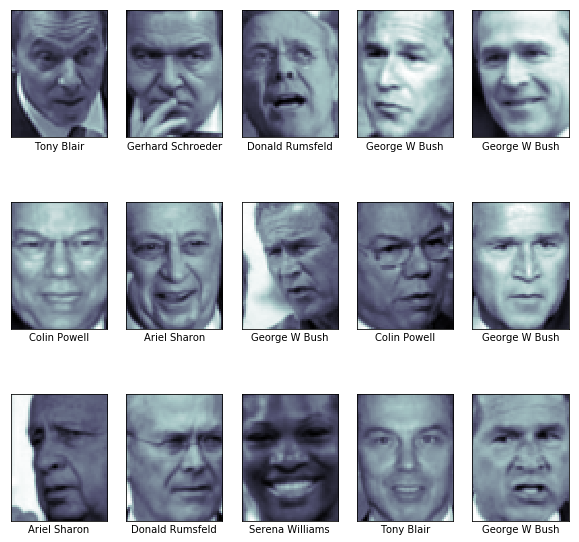

In [3]:
# Set up subplots
fig, ax = plt.subplots(3, 5)

fig.set_figheight(10)
fig.set_figwidth(10)

for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap='bone')
    axi.set(xticks=[], yticks=[],
            xlabel=faces.target_names[faces.target[i]])

Split data into testing and training sets

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=42)

Shuffle the order of the training data to prevent bias.

In [5]:
shuffle_index = np.random.permutation(len(y_train))
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

Below we scale the data.<br>
We have found that even without performing PCA (which requires scaling) that for this classification problem scaling the data does improve accuracy.<br>
That said, we do employ PCA below, so we need to scale the data.

In [6]:
# Scale the data by fitting to the training set
scaler = StandardScaler().fit(X_train)

# Apply transform to both the training set and the test set
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

Now perform Principle Component analysis and keep only enough features to explain at least 95% of the combined variance.

In [7]:
pca = PCA(n_components=0.95)
pca.fit(X_train)

# Apply PCA mapping transoformation to the training and testing datasets
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

print("Number of Principle Components: ", pca.n_components_)

Number of Principle Components:  156


We now implement hyperparameter tuning over these features after the PCA mapping to find the optimal model parameters.<br>
We choose the range of values to choose for gamma and C by noting the following.<br>
If gamma is very large we know this will induce extreme overfitting. We thus want gamma to either be small or very small, hence the chosen range.<br>
If C is very small it will create a very simple decision function, which leads to extreme underfitting. We thus consider values for C ranging from somewhat small to very large.

In [8]:
param_grid = {'gamma': [1e-09,1e-06, 0.0001, 0.001, 0.01, 0.1, 1], 
              'C': [2,1e1, 1e2, 1e3, 1e4, 1e5]}
clf = SVC()

clf_cv = GridSearchCV(clf, param_grid, scoring='accuracy', cv=5)
clf_cv.fit(X_train_pca, y_train)

params_optimal = clf_cv.best_params_

print("Best Score (accuracy): %f" % clf_cv.best_score_)
print("Optimal Hyperparameter Values: ", params_optimal)
print("\n")

Best Score (accuracy): 0.801709
Optimal Hyperparameter Values:  {'C': 10.0, 'gamma': 0.0001}




Below we note the optimal values for gamma and C, as found from the above hyperparameter tuning.

In [9]:
opt_C = 1000
opt_gamma = 1e-06

There are two main choices for employing Support Vector Machine for classification of this sort. We can either choose a linear function or a kernalized function.<br>
We note that in general images are not linearly separable, as pixels tend to be highly correlated to pixels near them. We thus choose to implement kernelized SMV using the PCA-fit features.

In [10]:
svm_clf_pca = SVC(C=opt_C, gamma=opt_gamma)
svm_clf_pca.fit(X_train_pca, y_train)

SVC(C=1000, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=1e-06, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

Before testing this model on the test data we first see how it performs on the train data.

In [11]:
y_train_predicted = svm_clf_pca.predict(X_train_pca)

accuracy_score_test = np.mean(y_train_predicted == y_train)

print("\nAccuracy: ", accuracy_score_test)

print("\nTrain Confusion Matrix:")
print(confusion_matrix(y_train, y_train_predicted))

print("\nClassification Report:")
print(classification_report(y_train, y_train_predicted))


Accuracy:  0.964957264957265

Train Confusion Matrix:
[[ 59   2   0   0   0   0   0   0   0   0   0   0]
 [  0 164   0   6   0   0   0   0   0   0   0   0]
 [  0   1  89   3   1   0   0   0   0   0   0   0]
 [  0   5   1 383   1   0   0   0   0   0   0   0]
 [  0   0   0   2  83   0   0   0   0   0   0   0]
 [  0   0   0   0   0  54   0   0   0   0   0   0]
 [  0   0   0   3   0   0  39   0   0   0   0   0]
 [  0   0   0   0   0   0   0  41   0   0   0   0]
 [  0   1   0   3   0   0   0   0  33   0   0   0]
 [  0   0   0   0   1   0   0   0   0  48   0   0]
 [  0   0   0   0   0   0   0   0   0   0  43   0]
 [  0   2   1   5   2   0   0   0   1   0   0  93]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.98        61
           1       0.94      0.96      0.95       170
           2       0.98      0.95      0.96        94
           3       0.95      0.98      0.96       390
           4       0.94      0.98    

We now see how this model works on the testing data.

In [12]:
# Examine results with using PCA on the Test Set

y_test_predicted = svm_clf_pca.predict(X_test_pca)

accuracy_score_test = np.mean(y_test_predicted == y_test)
print("\nAccuracy: ", accuracy_score_test)


print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))
# 

print("\nClassification Report:")
print(classification_report(y_test, y_test_predicted))


Accuracy:  0.8461538461538461

Test Confusion Matrix:
[[ 12   2   0   1   0   0   0   1   0   0   0   0]
 [  1  63   0   2   0   0   0   0   0   0   0   0]
 [  1   0  19   3   1   0   0   0   1   0   0   2]
 [  2   2   6 124   0   0   0   3   0   1   1   1]
 [  0   0   2   3  18   0   0   1   0   0   0   0]
 [  0   2   0   2   1  12   0   0   0   0   0   0]
 [  0   0   0   4   1   0   4   1   0   0   0   0]
 [  0   0   2   0   0   0   0  12   0   0   0   0]
 [  0   1   0   0   0   0   0   0  14   0   0   1]
 [  0   1   0   0   0   0   0   0   0  10   0   0]
 [  0   1   0   0   0   1   0   0   0   0   7   0]
 [  0   0   0   3   2   0   0   0   0   0   0  35]]

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.75      0.75        16
           1       0.88      0.95      0.91        66
           2       0.66      0.70      0.68        27
           3       0.87      0.89      0.88       140
           4       0.78      0.75    

The above results are pretty good, but with more tuning we could probably get better.